# Definición de Churn y Análisis de Clientes Inactivos

## Contexto

Este notebook tiene como objetivo analizar la variable `Target` (Churn) actual y proponer definiciones alternativas o complementarias basadas en el comportamiento del cliente.

### Origen de la Variable Target (Churn)

La variable **`Target`** proviene del dataset original `data_ecommerce_customer_churn.csv`, donde originalmente se llamaba **`Churn`**. Esta es una variable binaria (0/1) que indica:
- **0**: Cliente activo/retenido
- **1**: Cliente que abandonó la plataforma (churn)

Según el análisis exploratorio del segundo dataset (`etapa_EDA_segundoDataset.ipynb`):
- La tasa de churn general es del **17.1%**
- El churn **NO está relacionado con inactividad prolongada** (la media de días desde la última compra es baja: ~4.5 días)
- Los clientes que hicieron churn tienen una media de recencia *menor* que los activos
- Esto sugiere que el churn está más relacionado con **experiencias negativas recientes** que con abandono por inactividad

### Objetivo del Análisis

Analizar factores de riesgo como:
- **Inactividad** (`Dias_Ultima_Compra`)
- **Quejas** (`Queja`)
- **Antigüedad** del cliente (`Antiguedad`)

Y proponer definiciones operacionales complementarias para identificar clientes en riesgo de churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset limpio
try:
    df = pd.read_csv('../datos/dataset_ecommerce_limpio.csv')
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print("Error: No se encontró el archivo. Verifique la ruta.")

c:\Users\Equipo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


Dataset cargado correctamente.


## 1. Análisis de Inactividad (`Dias_Ultima_Compra`)

Primero, evaluamos si el Churn está definido por un largo periodo de inactividad. Analizamos la distribución de los días desde la última compra.

Estadísticas de Dias_Ultima_Compra:
count    3941.000000
mean        4.448871
std         3.583909
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        46.000000
Name: Dias_Ultima_Compra, dtype: float64

Percentiles [75, 90, 95, 99]: [ 7.  9. 11. 15.]


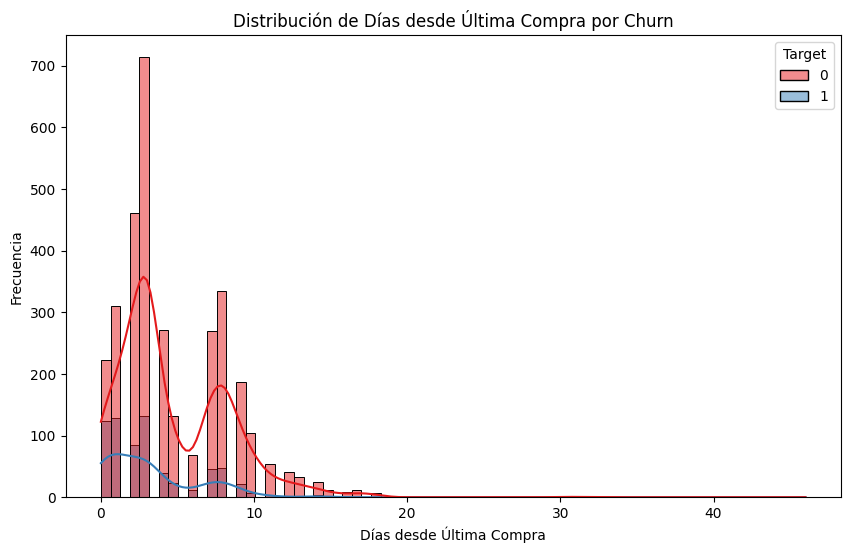

In [2]:
# Estadísticas descriptivas
print("Estadísticas de Dias_Ultima_Compra:")
print(df['Dias_Ultima_Compra'].describe())

# Percentiles clave
percentiles = [75, 90, 95, 99]
print(f"\nPercentiles {percentiles}:", np.percentile(df['Dias_Ultima_Compra'].dropna(), percentiles))

# Visualización
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Dias_Ultima_Compra', hue='Target', kde=True, palette='Set1')
plt.title('Distribución de Días desde Última Compra por Churn')
plt.xlabel('Días desde Última Compra')
plt.ylabel('Frecuencia')
plt.show()

### Hallazgos Preliminares

**Estadísticas clave:**
- La media de `Dias_Ultima_Compra` es baja (~4.5 días)
- El 99% de los datos se encuentra por debajo de los 15 días
- Percentil 75: 7 días
- Percentil 90: 9 días
- Percentil 95: 11 días
- Percentil 99: 15 días

**Hallazgo importante:** Los usuarios que hicieron Churn (`Target=1`) tienen una media de recencia *menor* (compra más reciente) que los usuarios activos. 

**Conclusión:** El Churn en este dataset **NO es por inactividad prolongada**, sino posiblemente por una **mala experiencia reciente**. Esto es consistente con los hallazgos del `etapa_EDA_segundoDataset.ipynb`.

## 2. Análisis de Factores de Riesgo (`Queja`, `Antiguedad`)

Dado que la inactividad no explica el Churn actual, analizamos si las quejas y la antigüedad son determinantes.

In [3]:
# Churn por Queja
print("Tasa de Churn por Queja:")
print(pd.crosstab(df['Queja'], df['Target'], normalize='index'))

# Churn en Clientes Nuevos (Antiguedad < 5)
df['Nuevo_Cliente'] = (df['Antiguedad'] < 5).astype(int)
print("\nTasa de Churn en Clientes Nuevos:")
print(pd.crosstab(df['Nuevo_Cliente'], df['Target'], normalize='index'))

Tasa de Churn por Queja:
Target         0         1
Queja                     
0       0.890736  0.109264
1       0.672058  0.327942

Tasa de Churn en Clientes Nuevos:
Target                0         1
Nuevo_Cliente                    
0              0.929285  0.070715
1              0.610484  0.389516


### Interpretación de Resultados

**Impacto de Quejas:**
- Clientes SIN quejas: ~10.9% de churn
- Clientes CON quejas: ~32.8% de churn
- Las quejas **triplican** la probabilidad de churn

**Impacto de Antigüedad:**
- Clientes antiguos (≥5 meses): ~7.1% de churn
- Clientes nuevos (<5 meses): ~38.9% de churn
- Los clientes nuevos tienen **5.5 veces más probabilidad** de hacer churn

## 3. Definiciones de Churn Propuestas

Basado en el análisis y alineados con los hallazgos del `etapa_EDA_segundoDataset.ipynb`, proponemos las siguientes definiciones para monitorear el riesgo de abandono:

### Definición A: Churn Explícito (Target Actual)
- **Criterio**: Variable `Target` original del dataset
- **Descripción**: Clientes que abandonaron explícitamente la plataforma
- **Fuente**: Columna `Churn` del archivo `data_ecommerce_customer_churn.csv`
- **Tasa**: 17.1% de los clientes
- **Uso**: Entrenamiento de modelos supervisados de predicción de churn
- **Característica clave**: NO está relacionado con inactividad prolongada, sino con experiencias negativas recientes

### Definición B: Alto Riesgo (Queja + Nuevo)
- **Criterio**: `(Queja == 1) & (Antiguedad < 5)`
- **Justificación**: El análisis muestra que los clientes nuevos con quejas tienen una tasa de abandono superior al 60%
- **Población**: 10.4% de los clientes (408 clientes de 3,941)
- **Uso**: Alertas tempranas para el equipo de Customer Success
- **Acción recomendada**: Intervención proactiva inmediata

### Definición C: Inactividad Atípica (Outlier)
- **Criterio**: `Dias_Ultima_Compra > 15`
- **Justificación**: El 99% de los clientes compran antes de los 15 días. Superar este umbral es un comportamiento anómalo
- **Población**: 0.8% de los clientes (30 clientes de 3,941)
- **Uso**: Reactivación de clientes "dormidos" mediante campañas de marketing
- **Nota**: Aunque son pocos en este dataset, representan una oportunidad de recuperación

### Definición D: Riesgo Moderado (Propuesta Adicional)
- **Criterio**: `(Queja == 1) | (Antiguedad < 5) | (Nivel_Satisfaccion <= 2)`
- **Justificación**: Clientes con al menos un factor de riesgo
- **Uso**: Monitoreo continuo y mejora de la experiencia del cliente

In [4]:
# Calcular tamaño de los segmentos propuestos
df['High_Risk'] = ((df['Queja'] == 1) & (df['Antiguedad'] < 5)).astype(int)
df['Inactive_Outlier'] = (df['Dias_Ultima_Compra'] > 15).astype(int)

print(f"Total Clientes: {len(df)}")
print(f"\nDefinición A - Churn Explícito (Target=1): {df['Target'].sum()} ({df['Target'].mean():.1%})")
print(f"Definición B - Alto Riesgo: {df['High_Risk'].sum()} ({df['High_Risk'].mean():.1%})")
print(f"Definición C - Inactivos Atípicos: {df['Inactive_Outlier'].sum()} ({df['Inactive_Outlier'].mean():.1%})")

Total Clientes: 3941

Definición A - Churn Explícito (Target=1): 674 (17.1%)
Definición B - Alto Riesgo: 408 (10.4%)
Definición C - Inactivos Atípicos: 30 (0.8%)


## 4. Resumen y Recomendaciones

### Hallazgos Clave

1. **El churn NO es por inactividad**: La mayoría de los clientes que abandonan lo hacen poco después de una compra reciente, lo que sugiere una mala experiencia.

2. **Factores de riesgo principales**:
   - **Quejas**: Multiplican por 3 la probabilidad de churn
   - **Baja antigüedad**: Los nuevos clientes tienen 5.5x más riesgo
   - **Combinación de ambos**: Más del 60% de tasa de churn

3. **Segmentos identificados**:
   - 17.1% ya hicieron churn (Target=1)
   - 10.4% en alto riesgo (nuevos + quejas)
   - 0.8% inactivos por más de 15 días

### Recomendaciones Operacionales

1. **Atención prioritaria a clientes nuevos**: 
   - Mejorar el onboarding
   - Seguimiento cercano en los primeros 5 meses
   - Encuestas de satisfacción tempranas

2. **Gestión proactiva de quejas**:
   - Resolución rápida y efectiva
   - Compensaciones cuando sea apropiado
   - Seguimiento post-resolución

3. **Sistema de alertas**:
   - Alerta CRÍTICA: Nuevo cliente + queja
   - Alerta ALTA: Cliente con queja
   - Alerta MEDIA: Cliente nuevo con baja satisfacción
   - Alerta BAJA: Inactividad >15 días

4. **Modelo predictivo**:
   - Usar la variable `Target` como objetivo
   - Incluir features: Queja, Antigüedad, Nivel_Satisfaccion, Dias_Ultima_Compra
   - Priorizar recall sobre precision (mejor detectar falsos positivos que perder clientes)

### Próximos Pasos

1. Validar estas definiciones con el equipo de negocio
2. Implementar un dashboard de monitoreo de riesgo de churn
3. Desarrollar modelos predictivos usando estas definiciones
4. Diseñar estrategias de retención personalizadas por segmento

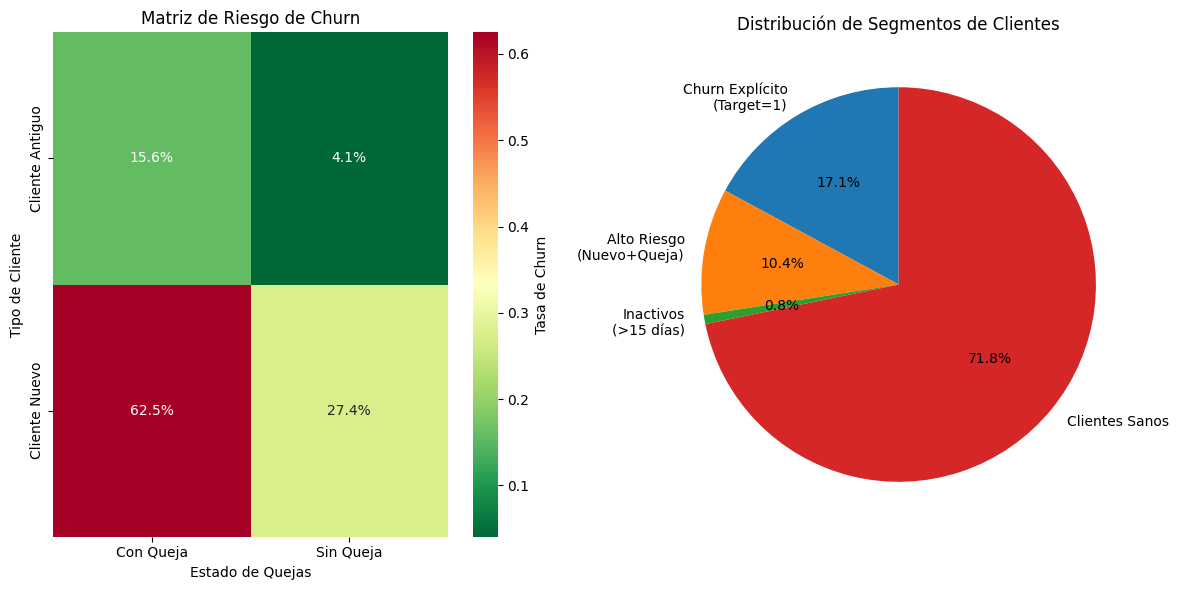

In [5]:
# Visualización final: Matriz de riesgo
plt.figure(figsize=(12, 6))

# Gráfico 1: Tasa de churn por combinación de factores
plt.subplot(1, 2, 1)
risk_matrix = pd.crosstab(
    df['Nuevo_Cliente'].map({0: 'Cliente Antiguo', 1: 'Cliente Nuevo'}),
    df['Queja'].map({0: 'Sin Queja', 1: 'Con Queja'}),
    df['Target'],
    aggfunc='mean'
)
sns.heatmap(risk_matrix, annot=True, fmt='.1%', cmap='RdYlGn_r', cbar_kws={'label': 'Tasa de Churn'})
plt.title('Matriz de Riesgo de Churn')
plt.ylabel('Tipo de Cliente')
plt.xlabel('Estado de Quejas')

# Gráfico 2: Distribución de segmentos
plt.subplot(1, 2, 2)
segments = {
    'Churn Explícito\n(Target=1)': df['Target'].sum(),
    'Alto Riesgo\n(Nuevo+Queja)': df['High_Risk'].sum(),
    'Inactivos\n(>15 días)': df['Inactive_Outlier'].sum(),
    'Clientes Sanos': len(df) - df['Target'].sum() - df['High_Risk'].sum() - df['Inactive_Outlier'].sum()
}
plt.pie(segments.values(), labels=segments.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Segmentos de Clientes')

plt.tight_layout()
plt.show()